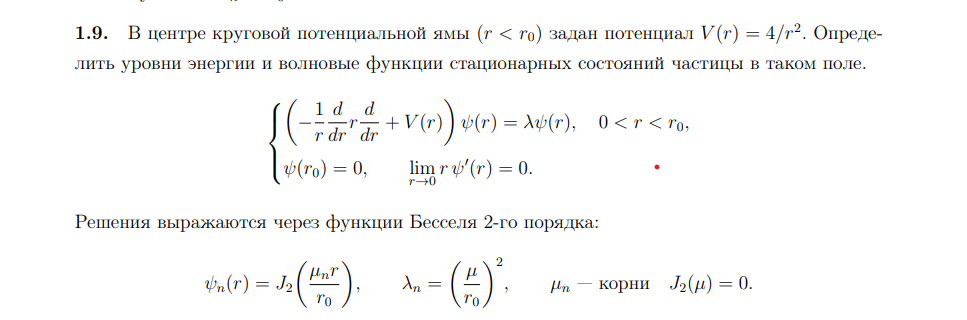

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

sns.set_theme()

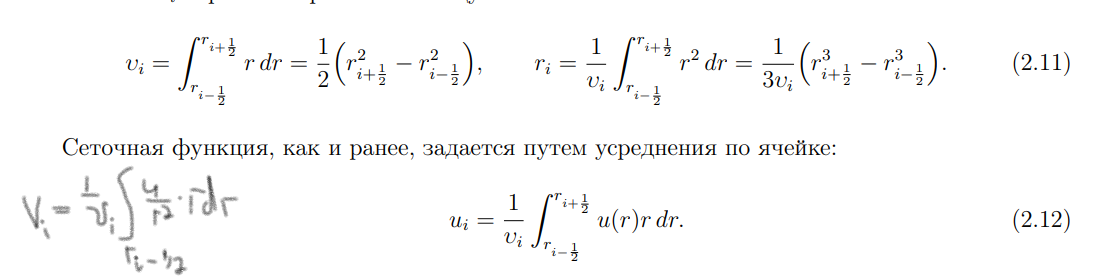

In [88]:
def volume_i(r_i_popolam: np.array) -> np.array:
    '''
    returns np.array with length = len(r_i_popolam) - 1
    '''
    return 0.5 * (r_i_popolam[1:] ** 2  - r_i_popolam[:-1] ** 2)
    

def r_i(r_i_popolam: np.array) -> np.array:
    '''
    returns np.array with length = len(r_i_poplam) - 1
    '''
    return 1 / (3 * volume_i(r_i_popolam)) * (r_i_popolam[1:] ** 3 - r_i_popolam[:-1] ** 3)


def V_i(r_i_popolam: np.array) -> np.array:
    '''
    
    '''
    return 4 * (np.log(r_i_popolam[1:]) - np.log(r_i_popolam[:-1]))

In [89]:
def params_init(start: float = 0.01,
                r0: float = 100,
                l: int = 10
                ) -> Tuple[np.array, np.array, np.array, np.array]:

    r_i_popolam = np.linspace(start, r0, l)
    volume = volume_i(r_i_popolam=r_i_popolam)
    center = r_i(r_i_popolam=r_i_popolam)
    field = V_i(r_i_popolam=r_i_popolam)

    return (r_i_popolam,
            center,
            volume,
            field)
            
r_i_popolam, volume, center, field = params_init()

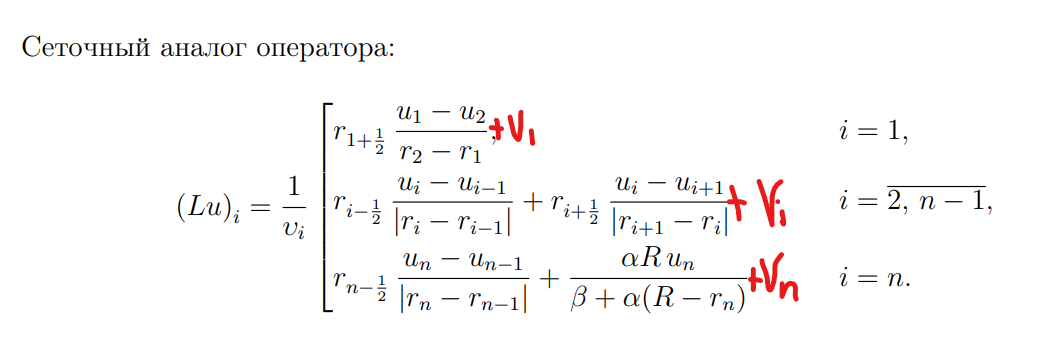

In [90]:
def new_params(eigenvalue_approx: float,
                        r_i_popolam: np.array = r_i_popolam,
                        center: np.array = center,
                        volume: np.array = volume,
                        field: np.array = field) -> Tuple[np.array, np.array, np.array]:
    
    A_array = np.empty_like(center)
    B_array  = np.empty_like(center)
    C_array = np.empty_like(center)

    B_array[0] = 1 / volume[0] * (r_i_popolam[1] / (center[1] - center[0]) + field[0])
    C_array[0] = - 1 / volume[0] * r_i_popolam[1] / (center[1] - center[0])

    A_array[1:-1] = - 1 / volume[1:-1] * r_i_popolam[1:-2] / np.abs(center[1:-1] - center[:-2])
    B_array[1:-1] = 1 / volume[1:-1] * (r_i_popolam[1:-2] / np.abs(center[:-2] - center[1:-1]) \
                                       + r_i_popolam[2:-1] / np.abs(center[2:] - center[1:-1]) + field[1:-1])
    C_array[1:-1] = - 1 / volume[1:-1] *  r_i_popolam[2:-1] / np.abs(center[2:] - center[1:-1])
    
    A_array[-1] = - 1 / volume[-1] * r_i_popolam[-2] / np.abs(center[-2] - center[-1])
    B_array[-1] =  1 / volume[-1] * (r_i_popolam[-2] / np.abs(center[-2] - center[-1]) + \
                                     r0 / (r0 - center[-1]) + field[-1])
    B_array = B_array - eigenvalue_approx

    return (A_array, B_array, C_array)

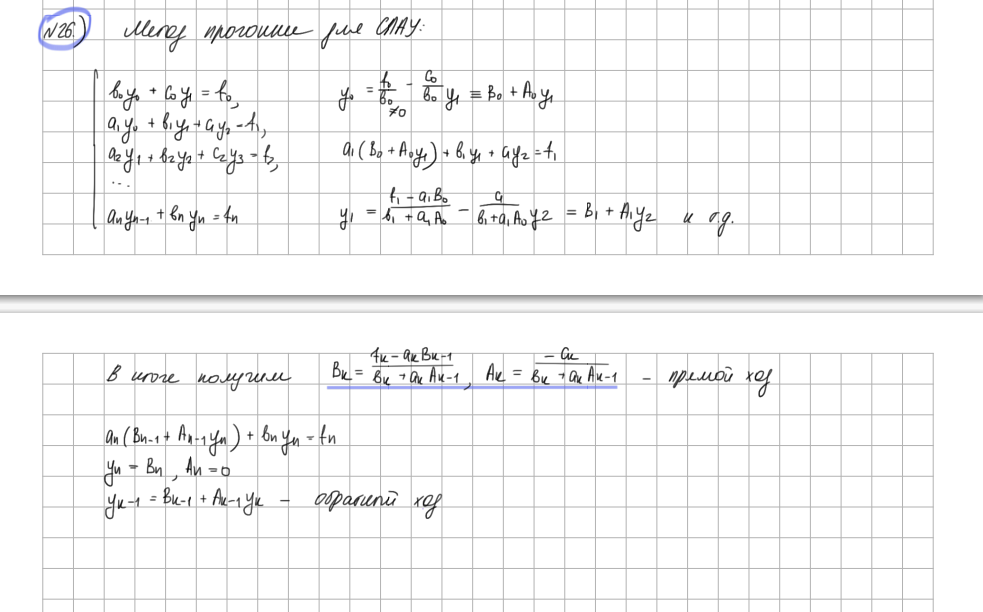

In [91]:
def thomas_algorithm(eigenvalue_approx: float,
                     last_approximation: np.array,
                     r_i_popolam : np.array = r_i_popolam,
                     center: np.array = center,
                     volume: np.array = volume,
                     field: np.array = field,
                     ) -> np.array:

    '''
    
    '''
    A_array, B_array, C_array = new_params(eigenvalue_approx = eigenvalue_approx,
                                                    r_i_popolam=r_i_popolam,
                                                    center=center,
                                                    volume=volume,
                                                    field=field)

    thomas_alg_B = np.empty_like(center)
    thomas_alg_A = np.empty_like(center)
    thomas_alg_B[0] = last_approximation[0] / B_array[0]
    thomas_alg_A[0] = - C_array[0] / B_array[0]
    

    for i in range(1, len(thomas_alg_B) - 1):
        thomas_alg_A[i] = - C_array[i] / (B_array[i] + A_array[i] * thomas_alg_A[i - 1])
        thomas_alg_B[i] = (last_approximation[i] - A_array[i] * thomas_alg_B[i - 1]) / \
                           (B_array[i] + A_array[i] * thomas_alg_A[i - 1])


    thomas_alg_B[-1] = (last_approximation[-1] - A_array[-1] * thomas_alg_B[-2]) / \
                        (B_array[-1] + A_array[-1] * thomas_alg_A[-2])
    thomas_alg_A[-1] = 0
    
    new_approximation = np.empty_like(last_approximation)
    new_approximation[-1] = thomas_alg_B[-1]

    for i in range(len(new_approximation) - 2, -1, -1):
        new_approximation[i] = thomas_alg_B[i] + thomas_alg_A[i] * new_approximation[i + 1]

    return new_approximation
    

In [92]:
def A_matmul_eigenfunction(eigenfunction_approx: np.array,
                           A_array: np.array,
                           B_array: np.array,
                           C_array: np.array) -> np.array:


    result = np.empty_like(eigenfunction_approx)
    result[0] = B_array[0] * eigenfunction_approx[0] + C_array[0] * eigenfunction_approx[1]
    
    for i in range(1, len(result) - 1):
        result[i] = A_array[i] * eigenfunction_approx[i - 1] + \
                    B_array[i] * eigenfunction_approx[i] + \
                    C_array[i] * eigenfunction_approx[i + 1] 

    result[-1] = A_array[-1] * eigenfunction_approx[-2] + \
                B_array[-1] * eigenfunction_approx[-1]
                
    return result

In [93]:
def rayleigh_method(eigenvalue_approx: float, 
                    eigenfunction_approx: np.array,
                    r_i_popolam=r_i_popolam,
                    center=center,
                    volume=volume,
                    field=field) -> Tuple[float, np.array]:


    new_eigenfunction_approx = thomas_algorithm(eigenvalue_approx = eigenvalue_approx,
                                                last_approximation = eigenfunction_approx,
                                                r_i_popolam=r_i_popolam,
                                                center=center,
                                                volume=volume,
                                                field=field) 
                                                
    A_array, B_array, C_array = new_params(eigenvalue_approx=0, 
                                            r_i_popolam=r_i_popolam,
                                            center=center,
                                            volume=volume,
                                            field=field)
    
    normed_eigenfunction_approx = new_eigenfunction_approx / (np.linalg.norm(new_eigenfunction_approx))

    new_eigenvalue_approx = A_matmul_eigenfunction(eigenfunction_approx=normed_eigenfunction_approx,
                                                    A_array=A_array,
                                                    B_array=B_array,
                                                    C_array=C_array).dot(normed_eigenfunction_approx)


    return (new_eigenvalue_approx, normed_eigenfunction_approx)

In [94]:
l=5000
start = 0.0001
r0 = 5
r_i_popolam, center, volume, field = params_init(start=start,r0=r0, l=l)

In [95]:
def find_eigenfunc_eigenval(start_eigenval: float) -> Tuple[float, np.array]:

    eigenfunc_approx = np.ones(l-1)

    for i in range(100):
        start_eigenval, eigenfunc_approx = rayleigh_method(start_eigenval, eigenfunc_approx,
                                                         r_i_popolam, center, volume, field)
    return (start_eigenval, eigenfunc_approx)

Корни фукнции бесселя второго порядка
1. 5.1356
2. 8.4172
3. 11.6198
4. 14.7783
5. 17.9300
6. 21.0631
7. 24.1905
8. 27.3135
9. 30.4330
10. 33.5490

In [96]:
approx_list = [i for i in range(1, 20)]
eigenval_list = []
eigenfunc_list = []
for i in approx_list:
    val, func = find_eigenfunc_eigenval(i)
    eigenval_list.append(val)
    eigenfunc_list.append(func)
np.sqrt(eigenval_list) * r0

array([ 5.1356223 ,  5.1356223 ,  5.1356223 ,  8.41724377, 11.61983977,
       11.61983977, 11.61983977, 11.61983977, 14.79594838, 11.61983977,
       14.79594838, 17.9598128 , 17.9598128 , 17.9598128 , 17.9598128 ,
       17.9598128 , 17.9598128 , 21.11698548, 17.9598128 ])

In [97]:
from mpmath import besselj
eigenval_list[0],  r0 * np.sqrt(eigenval_list[0]), besselj(2, r0 * np.sqrt(eigenval_list[0]))

(1.0549846565550192, 5.1356223005469825, mpf('4.3942945683534991e-10'))

In [98]:
def true_func(lam: float) -> np.array:

    bes = np.empty_like(center)
    for i, r in enumerate(np.sqrt(lam) * center):
        bes[i] = besselj(2, r)
    return bes / np.linalg.norm(bes)

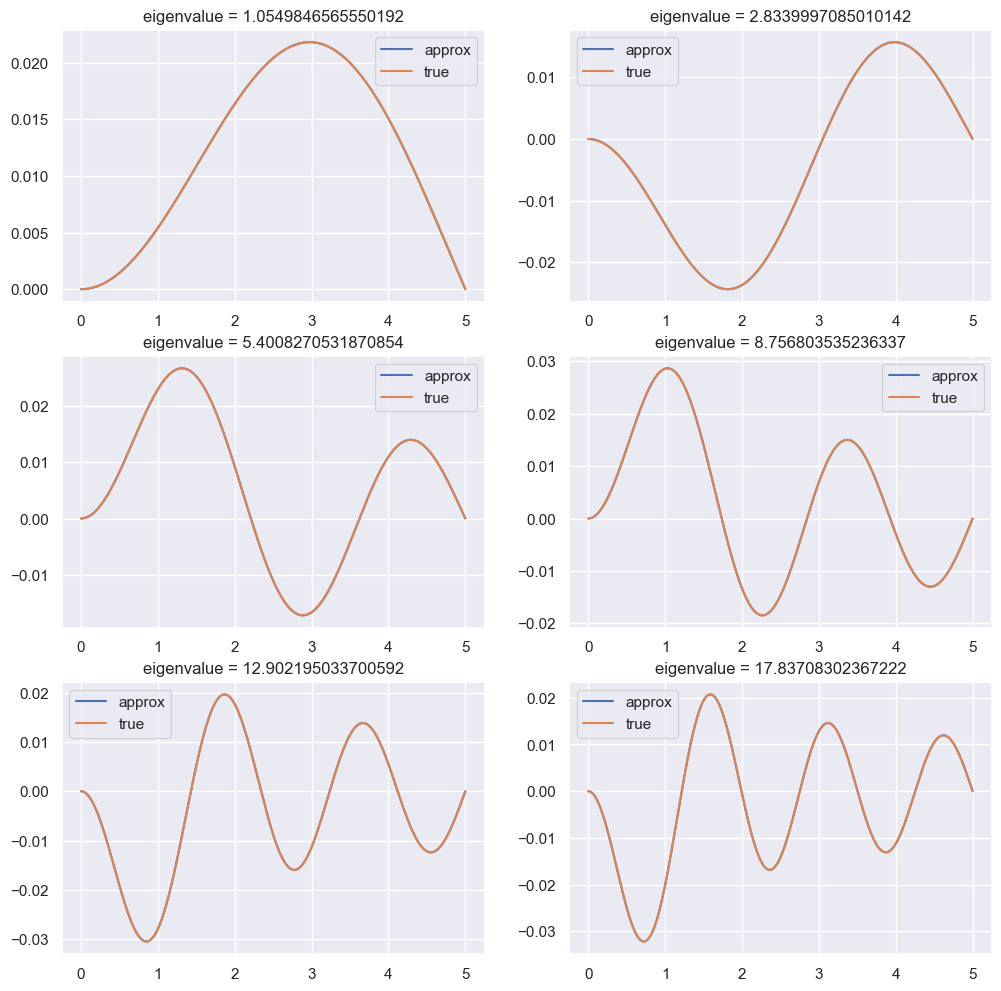

In [99]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

ax[0][0].set_title(f'eigenvalue = {eigenval_list[1]}')
ax[0][0].plot(center, eigenfunc_list[1], label='approx')
k = np.sign(eigenfunc_list[1][0] * true_func(eigenval_list[1])[0])
ax[0][0].plot(center, k * true_func(eigenval_list[1]), label='true')
ax[0][0].legend()


ax[0][1].set_title(f'eigenvalue = {eigenval_list[3]}')
ax[0][1].plot(center, eigenfunc_list[3], label='approx')
k = np.sign(eigenfunc_list[3][0] * true_func(eigenval_list[3])[0])
ax[0][1].plot(center, k * true_func(eigenval_list[3]), label='true')
ax[0][1].legend()


ax[1][0].set_title(f'eigenvalue = {eigenval_list[4]}')
ax[1][0].plot(center, eigenfunc_list[4], label='approx')
k = np.sign(eigenfunc_list[4][0] * true_func(eigenval_list[4])[0])
ax[1][0].plot(center, k * true_func(eigenval_list[4]), label='true')
ax[1][0].legend()



ax[1][1].set_title(f'eigenvalue = {eigenval_list[8]}')
ax[1][1].plot(center, eigenfunc_list[8], label='approx')
k = np.sign(eigenfunc_list[8][0] * true_func(eigenval_list[8])[0])
ax[1][1].plot(center, k * true_func(eigenval_list[8]), label='true')
ax[1][1].legend()


ax[2][0].set_title(f'eigenvalue = {eigenval_list[11]}')
ax[2][0].plot(center, eigenfunc_list[11], label='approx')
k = np.sign(eigenfunc_list[11][0] * true_func(eigenval_list[11])[0])
ax[2][0].plot(center, k * true_func(eigenval_list[11]), label='true')
ax[2][0].legend()

ax[2][1].set_title(f'eigenvalue = {eigenval_list[17]}')
ax[2][1].plot(center, eigenfunc_list[17], label='approx')
k = np.sign(eigenfunc_list[17][0] * true_func(eigenval_list[11])[0])
ax[2][1].plot(center, k * true_func(eigenval_list[17]), label='true')
ax[2][1].legend()